# Analysis of an optimal solution

In [1]:
import copy
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx
from ItalySetup import ItalySetup
from covidOCP import COVIDVaccinationOCP, COVIDParametersOCP
from main import pick_scenario, build_scenario
import seaborn as sns
import datetime
import pickle
import glob

nx = 9
states_names = ['S', 'E', 'P', 'I', 'A', 'Q', 'H', 'R', 'V']

when = 'future'
file_prefix = f'week'

nnodes = 107  # nodes
ndays = 30

setup = ItalySetup(nnodes, ndays, when)
M = setup.nnodes
N = len(setup.model_days) - 1

with open(f'italy-data/parameters_{nnodes}_{when}.pkl', 'rb') as inp:
    p = pickle.load(inp)

Loaded Italy Setup with 107 nodes.


In [22]:
files_n = {'Optimistic':  'model_output/scenarios_new_30/U-r300-t479700-id10-opi-107_30.csv',
           'Pessimistic': 'model_output/scenarios_new_30/L-r300-t479700-id11-opi-107_30.csv'}

In [7]:
#dates_interm = pd.date_range(setup.start_date, setup.end_date, freq='30D')
#dates_interm

In [23]:
results = {}

methods = ['opi', 'inc', 'pop']
for scn, fn in files_n.items():
    results[scn] = {}
    # Find baseline:
    scn_letter = fn.split('-')[0][-1]
    baseline_fn = glob.glob(f'model_output/scenarios_new_30/{scn_letter}*novacc*.csv')[0]
    bl = pd.read_csv(baseline_fn, index_col= 'date', parse_dates=True)
    for met in methods: 
        md = pd.read_csv(fn.replace('opi', met), index_col= 'date', parse_dates=True)

        res = setup.shp.copy()
        res['vacc'] = np.nan
        res['Send'] = np.nan
        for i, node in enumerate(setup.ind2name):

            mdp = md[md['place']==node]
            blp = bl[bl['place']==node]

            total_vacc = mdp[ mdp['comp']=='vacc']['value'].sum()
            Send       = mdp[ mdp['comp']=='S']['value'][-1]
            ndays_vacc = len(mdp[(mdp['comp']=='vacc') & (mdp['value']>1)])
            total_inf  = mdp[ mdp['comp'].isin(['E', 'P', 'I', 'A', 'Q', 'H', 'R']) & (mdp.index == str(setup.end_date))]['value'].sum()
            new_inf    = mdp[ mdp['comp']=='yell']['value'].sum() # mdp[ mdp['comp'].isin(['E', 'P', 'I', 'A']) & (mdp.index == str(setup.end_date))]['value'].sum()
            new_inf_bl = blp[ blp['comp']=='yell']['value'].sum()

            res.loc[i, 'total_vacc'] = total_vacc
            res.loc[i, 'Send'] =       Send
            res.loc[i, 'ndays_vacc'] = ndays_vacc
            res.loc[i, 'total_inf'] =  total_inf
            res.loc[i, 'new_inf'] =    new_inf
            res.loc[i, 'new_inf_bl'] =    new_inf_bl
            res.loc[i, 'averted'] = new_inf_bl - new_inf
            res.loc[i, 'Send_pop'] = Send/setup.pop_node[i]
            res.loc[i, 'population'] = setup.pop_node[i] # overwrite 

            #for dt in dates_interm:
            #    res.loc[i, f'total_vacc{str(dt.date())}'] = mdp[(mdp['comp']=='vacc') & (mdp.index < dt)]['value'].sum()
        results[scn][met] = res

In [24]:
for scn, fn in files_n.items():
    results[scn]['Optimal'] = results[scn].pop('opi')
    results[scn]['Population'] = results[scn].pop('pop')
    results[scn]['Incidence'] = results[scn].pop('inc')


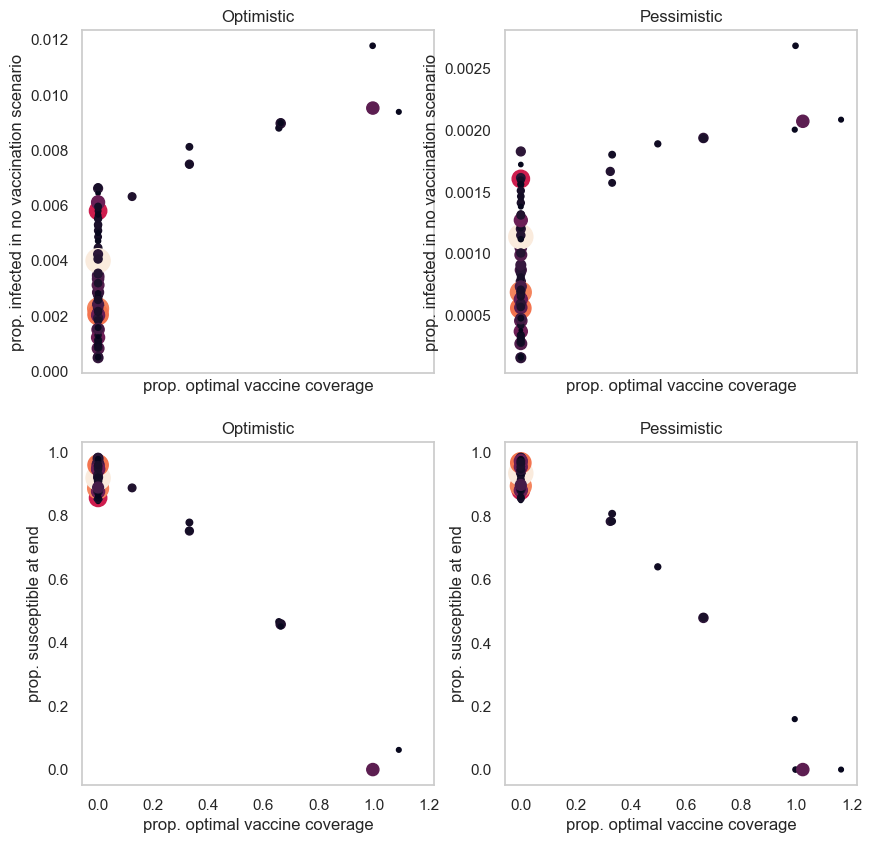

In [25]:
fig, axes = plt.subplots(2,2, figsize=(10,10), dpi = 100, sharex=True)


for i, (scn_name, res) in enumerate(results.items()):
    res = res['Optimal']
    
    ax = axes[0,i]
    ax.scatter(res['total_vacc']/res['population'], 
               res['new_inf_bl']/res['population'], 
               s=res.population/max(res.population)*300, 
               c=res.population/max(res.population)*300)

    ax.grid()
    #ax.set( yscale="log", xscale="log") #
    ax.set_xlabel('prop. optimal vaccine coverage')
    ax.set_ylabel('prop. infected in no vaccination scenario')
    ax.set_title(f'{scn_name}')
    
    ax = axes[1,i]
    ax.scatter(res['total_vacc']/res['population'], 
           res['Send']/res['population'], 
           s=res.population/max(res.population)*300, 
           c=res.population/max(res.population)*300)

    ax.grid()
    #ax.set( yscale="log", xscale="log") #
    ax.set_xlabel('prop. optimal vaccine coverage')
    ax.set_ylabel('prop. susceptible at end')
    ax.set_title(f'{scn_name}')
fig.savefig('figures/scatter_all.pdf')

In [ ]:
Total # of vaccines, Total averted cases, **%** Susceptible left at the end.

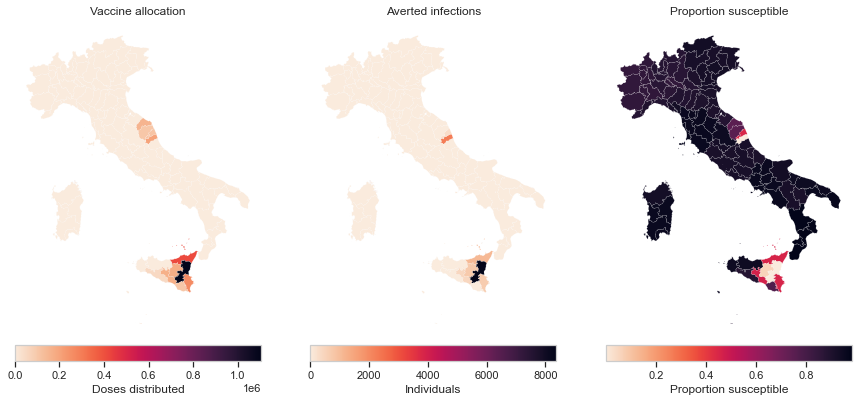

In [27]:
fig, axes = plt.subplots(1,3, figsize=(15, 10))
from mpl_toolkits.axes_grid1 import make_axes_locatable
res = results['Optimistic']['Optimal']

plt_infos = {'total_vacc': 
             {'legend':'Doses distributed',
              'title': 'Vaccine allocation'},
            'averted': 
             {'legend':'Individuals',
              'title': 'Averted infections'},
            'Send_pop': 
             {'legend':'Proportion susceptible',
              'title': 'Proportion susceptible'}}


for i, (colname, details) in enumerate(plt_infos.items()):
    ax=axes.flat[i]
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="5%", pad=0.1)
    mp = res.plot(ax = ax, column=colname, cmap='rocket_r', lw = .1, edgecolor="white", cax = cax, legend=True, legend_kwds={'label': details['legend'],     'orientation': "horizontal"})
    ax.set_title(details['title'])
    ax.axis('off')
    
    #divider = make_axes_locatable(ax)
    #cax = divider.append_axes("right", size="5%", pad=0.05)

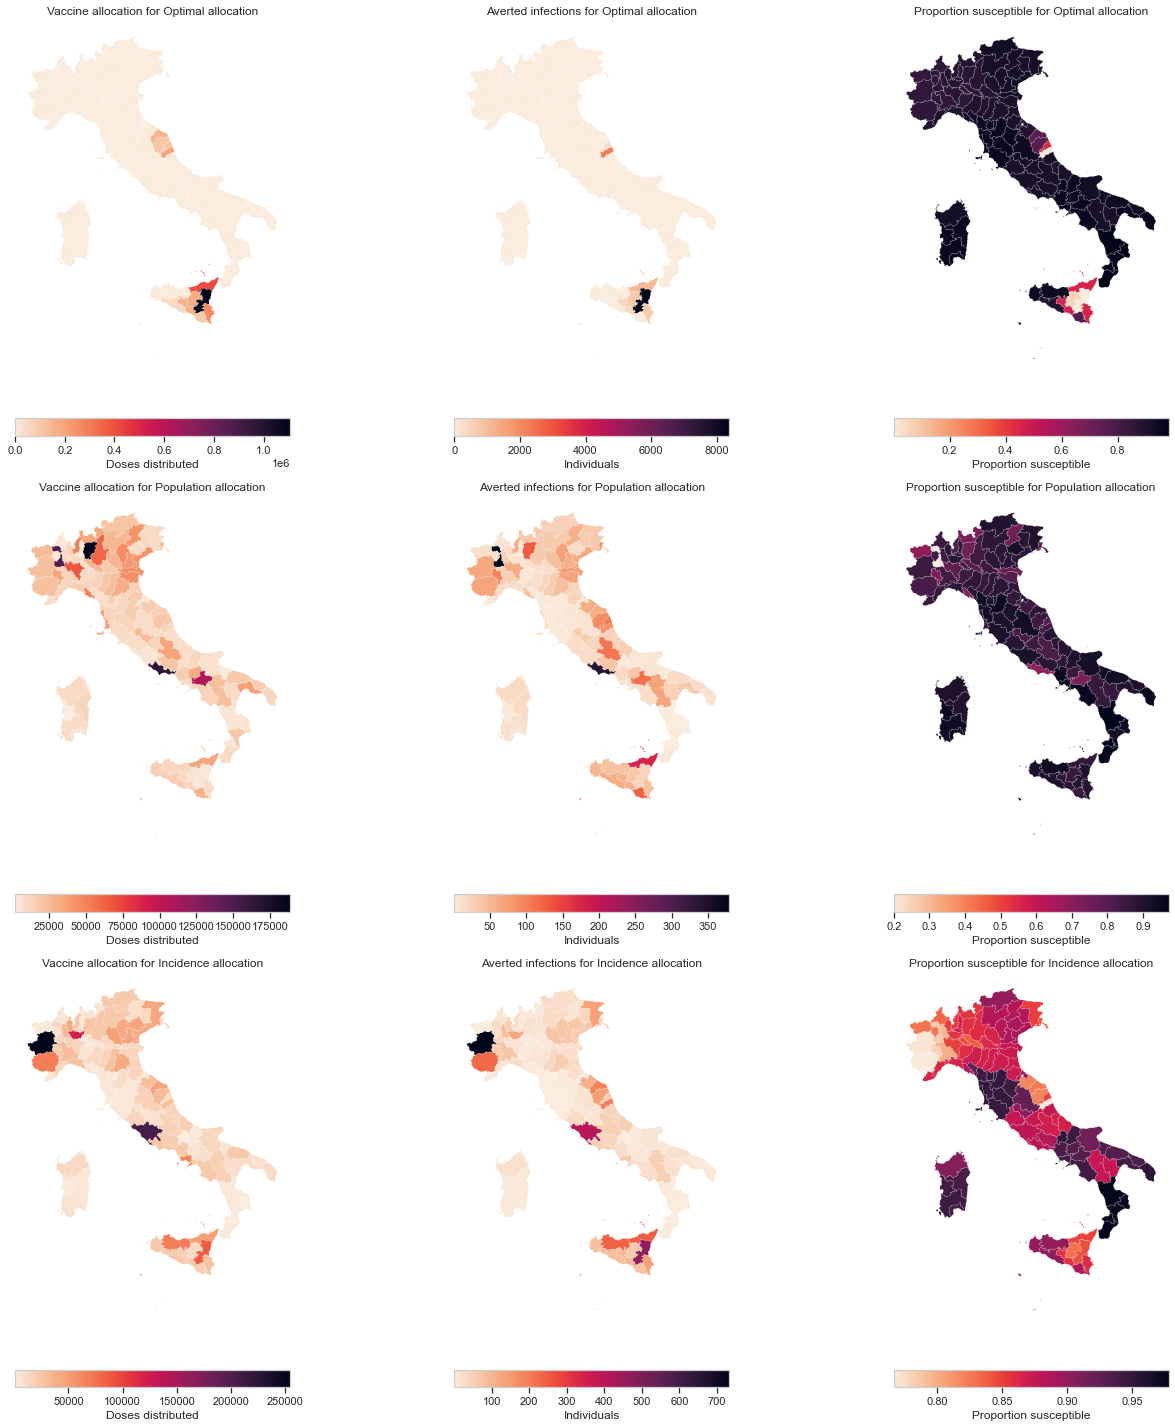

In [28]:
fig, axes_all = plt.subplots(3,3, figsize=(20, 20))
from mpl_toolkits.axes_grid1 import make_axes_locatable
res = results['Optimistic']

plt_infos = {'total_vacc': 
             {'legend':'Doses distributed',
              'title': 'Vaccine allocation'},
            'averted': 
             {'legend':'Individuals',
              'title': 'Averted infections'},
            'Send_pop': 
             {'legend':'Proportion susceptible',
              'title': 'Proportion susceptible'}}
j = 0
for met, res in res.items():
    axes = axes_all[j]
    j+=1
    for i, (colname, details) in enumerate(plt_infos.items()):
        ax=axes.flat[i]
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("bottom", size="5%", pad=0.6)
        mp = res.plot(ax = ax, column=colname, cmap='rocket_r', lw = .1, edgecolor="white", cax = cax, legend=True, legend_kwds={'label': details['legend'],     'orientation': "horizontal"})
        ax.set_title(details['title'] + f' for {met} allocation')
        ax.axis('off')
fig.tight_layout()
fig.savefig('figures/map_all.pdf')

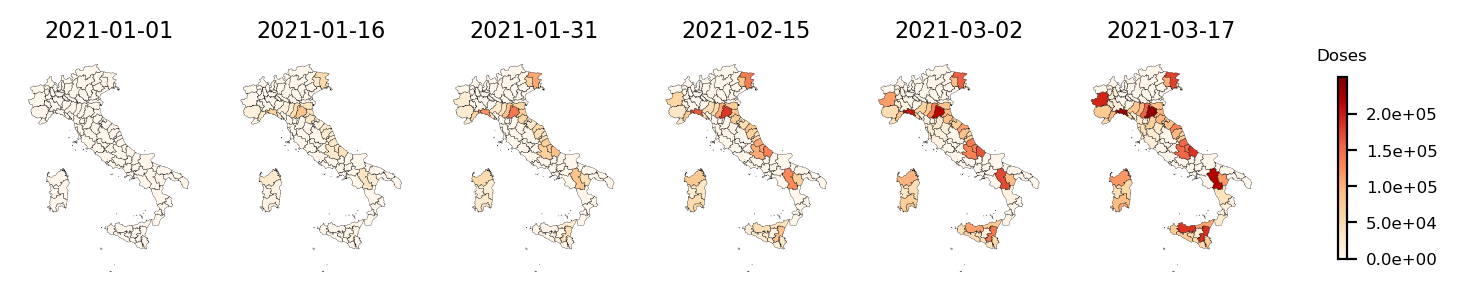

In [193]:
fig, ax = plt.subplots(1, len(dates_interm),figsize=(10, 30), dpi = 200)

cmap = mpl.cm.OrRd #viridis  #sns.cm.rocket  'OrRd'
vmin = 0
vmax = 2.5e5#max(setup.shp.total_vacc)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
sm._A = []
cmap = fig.colorbar(sm, ax=ax.ravel().tolist(), shrink=.04, ticks=np.arange(0, vmax, vmax/5))
cmap.ax.set_title('Doses', fontsize=6)

for i, dt in enumerate(dates_interm):
    setup.shp.plot(ax = ax.flat[i], column=f'total_vacc{str(dt.date())}', 
                          edgecolor="black", lw = .1, cmap = 'OrRd', vmin=vmin, vmax=vmax)
    #facecolor="none",
    ax.flat[i].axis('off')
    ax.flat[i].set_title(str(dt.date()), fontsize = 8)
#fig.subplots_adjust(right=0.8)
# put colorbar at desire position
#cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
#fig.colorbar(im, cax=cbar_ax)
#fig.colorbar(ax.flat[i])
cmap.ax.set_yticklabels(['{:.1e}'.format(x) for x in np.arange(0, vmax,vmax/5)], fontsize=6);#, weight='bold')
fig.savefig('figures/map_tf.pdf')

In [185]:
max(setup.shp.total_vacc)

257010.71131244302

In [186]:
1e5

100000.0

In [99]:
vmax/

0.5744113734157691

57441.137341576905

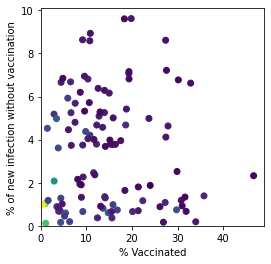

In [18]:
import seaborn as sns
fig, ax = plt.subplots(1,1,figsize=(4, 4))
plt.scatter(setup.shp['total_vacc']/setup.shp['population']*100, setup.shp['new_inf_bl']/setup.shp['population']*100, c= setup.shp['population'])
ax.set_xlabel("% Vaccinated")
ax.set_ylabel("% of new infection without vaccination");
ax.set_xlim(0)
ax.set_ylim(0)
fig.savefig('figures/scatter_vacc_inf.pdf')

/Users/chadi/opt/miniconda3/envs/ocp-covid/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


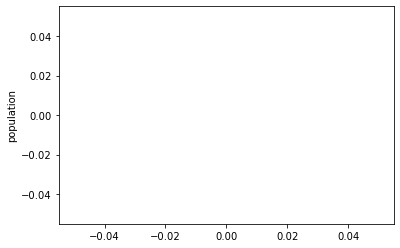

In [17]:
ax = sns.scatterplot(setup.shp['vacc'], setup.shp['population'], hue=setup.shp['Rend'])
ax.get_legend().remove();
#ax.set(xscale="log", yscale="log")

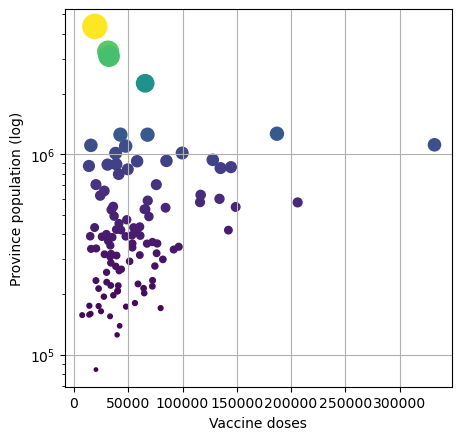

In [14]:
fig, ax = plt.subplots(figsize=(5,5), dpi = 100)
ax.scatter(setup.shp['total_vacc'], 
           setup.shp['population'],
           s=setup.shp.population/max(setup.shp.population)*300, 
           c=setup.shp.population/max(setup.shp.population)*300)
#ax.get_legend().remove();
ax.grid()
ax.set_ylabel('Province population (log)')
ax.set_xlabel('Vaccine doses')
ax.set(yscale="log") 
fig.savefig('figures/scatter_vacc_pop.pdf')

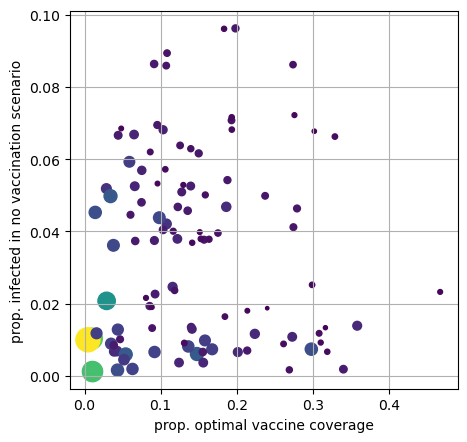

In [15]:
fig, ax = plt.subplots(figsize=(5,5), dpi = 100)
ax.scatter(setup.shp['total_vacc']/setup.shp['population'], 
           setup.shp['new_inf_bl']/setup.shp['population'], 
           s=setup.shp.population/max(setup.shp.population)*300, 
           c=setup.shp.population/max(setup.shp.population)*300)
#ax.get_legend().remove();
ax.grid()
#ax.set( yscale="log", xscale="log") #
ax.set_xlabel('prop. optimal vaccine coverage')
ax.set_ylabel('prop. infected in no vaccination scenario')
fig.savefig('figures/scatter_vacc_inf.pdf')

/Users/chadi/opt/miniconda3/envs/ocp-covid/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


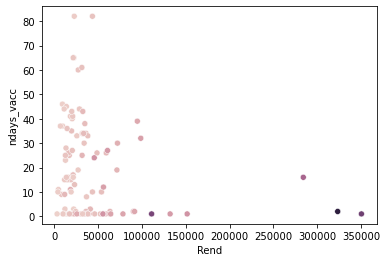

In [196]:
ax = sns.scatterplot(setup.shp['Rend'], setup.shp['ndays_vacc'], hue=setup.shp['population'])
ax.get_legend().remove();

In [202]:
setup.shp.columns

Index(['COD_RIP', 'COD_REG', 'COD_PROV', 'COD_CM', 'COD_UTS', 'DEN_PROV',
       'DEN_CM', 'DEN_UTS', 'SIGLA', 'TIPO_UTS', 'Shape_Leng', 'Shape_Area',
       'geometry', 'name', 'population', 'mobile_fraction', 'vacc', 'Rend',
       'total_vacc', 'ndays_vacc', 'total_inf', 'new_inf', 'new_inf_bl',
       'total_vacc2021-01-01', 'total_vacc2021-01-10', 'total_vacc2021-01-19',
       'total_vacc2021-01-28', 'total_vacc2021-02-06', 'total_vacc2021-02-15',
       'total_vacc2021-02-24', 'total_vacc2021-03-05', 'total_vacc2021-03-14',
       'total_vacc2021-03-23', 'total_vacc2021-01-16', 'total_vacc2021-01-31',
       'total_vacc2021-03-02', 'total_vacc2021-03-17'],
      dtype='object')

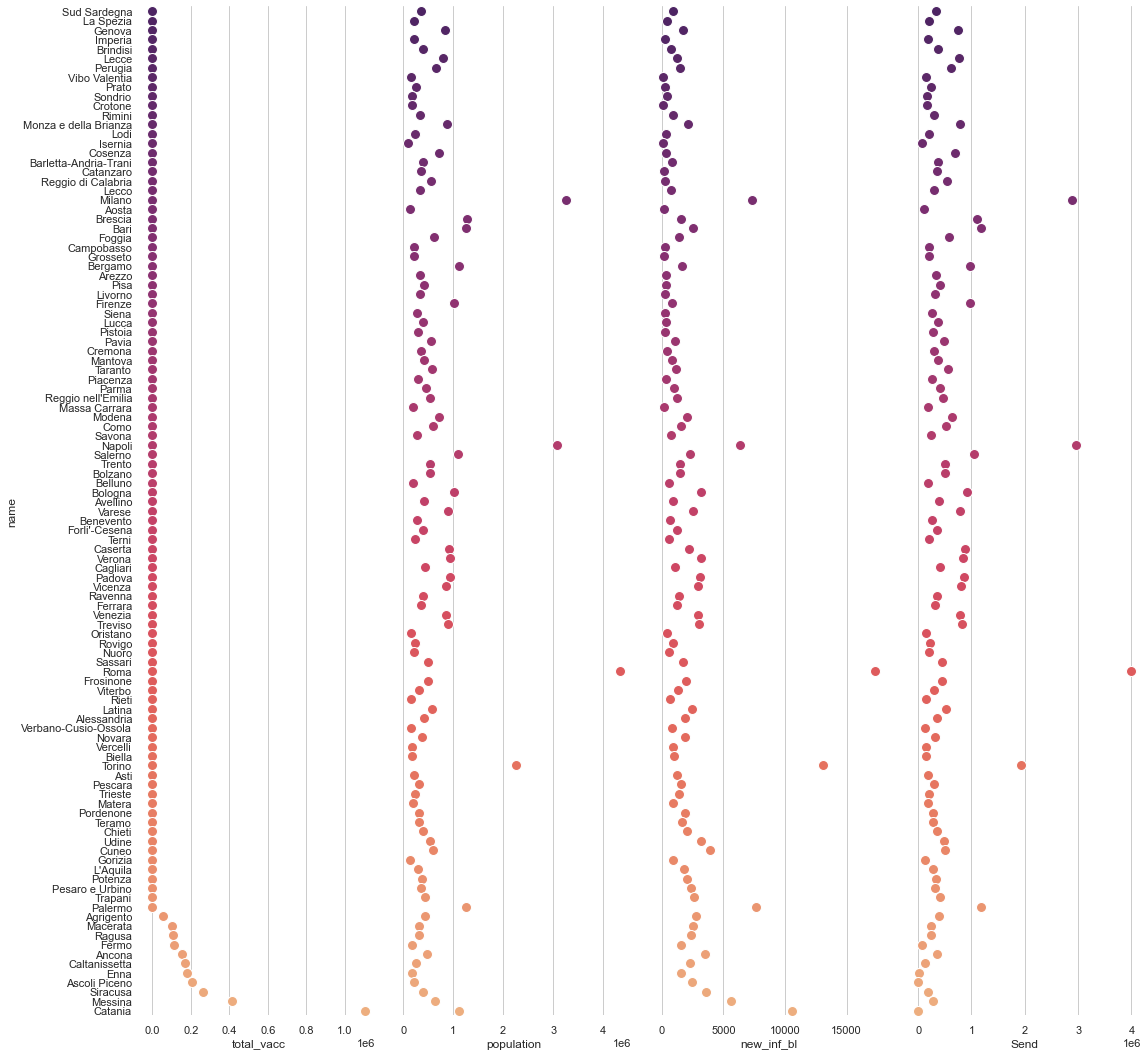

In [29]:
import seaborn as sns
sns.set_theme(style="whitegrid")

df = results['Optimistic']['Optimal']

df = df.sort_values('total_vacc', ascending=False)
df = df[df.columns[13:]]

#for col in df.columns[2:]:
#    df[col] = df[col]/df.population

# Make the PairGrid
g = sns.PairGrid(df.sort_values('total_vacc', ascending=True),
                 x_vars=['total_vacc', 'population', 'new_inf_bl', 'Send'], y_vars=["name"],
                 height=15, aspect=.25)

# Draw a dot plot using the stripplot function
g.map(sns.stripplot, size=10, orient="h", jitter=False,
      palette="flare_r", linewidth=1, edgecolor="w")

# Use the same x axis limits on all columns and add better labels
#g.set(xlim=(0, 25), xlabel="Crashes", ylabel="")

# Use semantically meaningful titles for the columns
#titles = ["Total crashes", "Speeding crashes", "Alcohol crashes",
#          "Not distracted crashes", "No previous crashes"]

#for ax, title in zip(g.axes.flat, titles):#

#    # Set a different title for each axes
#    ax.set(title=title)

    # Make the grid horizontal instead of vertical
#    ax.xaxis.grid(False)
#    ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)